# MLP Regression (PyTorch - GPU)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Check GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.09 GB


## Load Data

In [3]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

print(f"Input files: {len(input_files)}")
print(f"Output files: {len(output_files)}")

Input files: 18
Output files: 18


In [4]:
input_dfs = []
output_dfs = []

for input_file, output_file in zip(input_files[:5], output_files[:5]):
    input_dfs.append(pd.read_csv(input_file))
    output_dfs.append(pd.read_csv(output_file))

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f"Input shape: {input_df.shape}")
print(f"Output shape: {output_df.shape}")

Input shape: (1399311, 23)
Output shape: (159814, 6)


## Merge Data

In [5]:
merged_df = input_df.merge(
    output_df, 
    on=['game_id', 'play_id', 'nfl_id'],
    suffixes=('_input', '_output')
)

print(f"Merged shape: {merged_df.shape}")

Merged shape: (4634163, 26)


## Prepare Features

In [6]:
feature_cols = ['x_input', 'y_input', 's', 'a', 'dir', 'o']
target_cols = ['x_output', 'y_output']

X = merged_df[feature_cols].fillna(0)
y = merged_df[target_cols].fillna(0)

print(f"Features: {X.shape}")
print(f"Targets: {y.shape}")

Features: (4634163, 6)
Targets: (4634163, 2)


## Feature Distributions

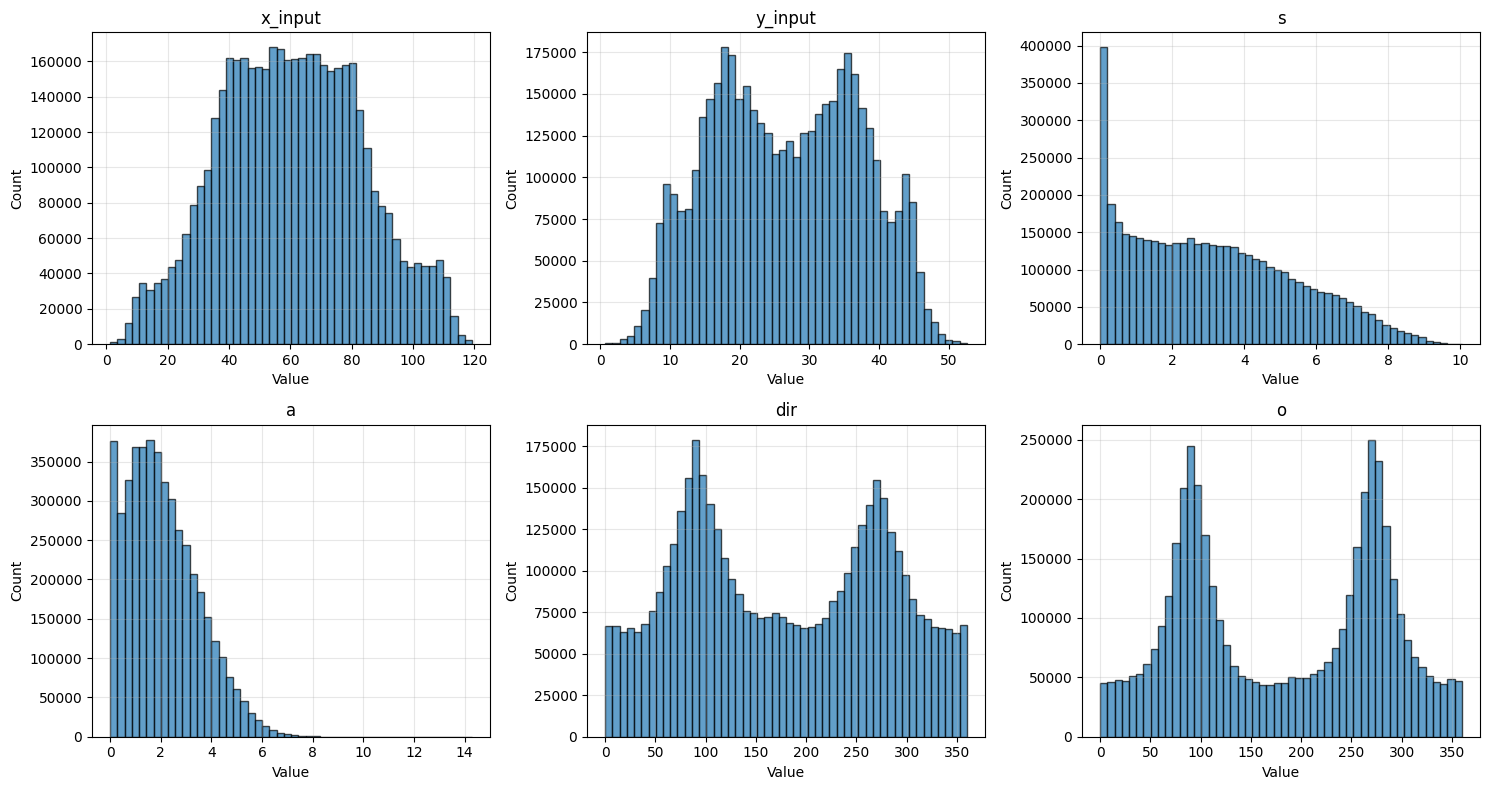

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Correlations

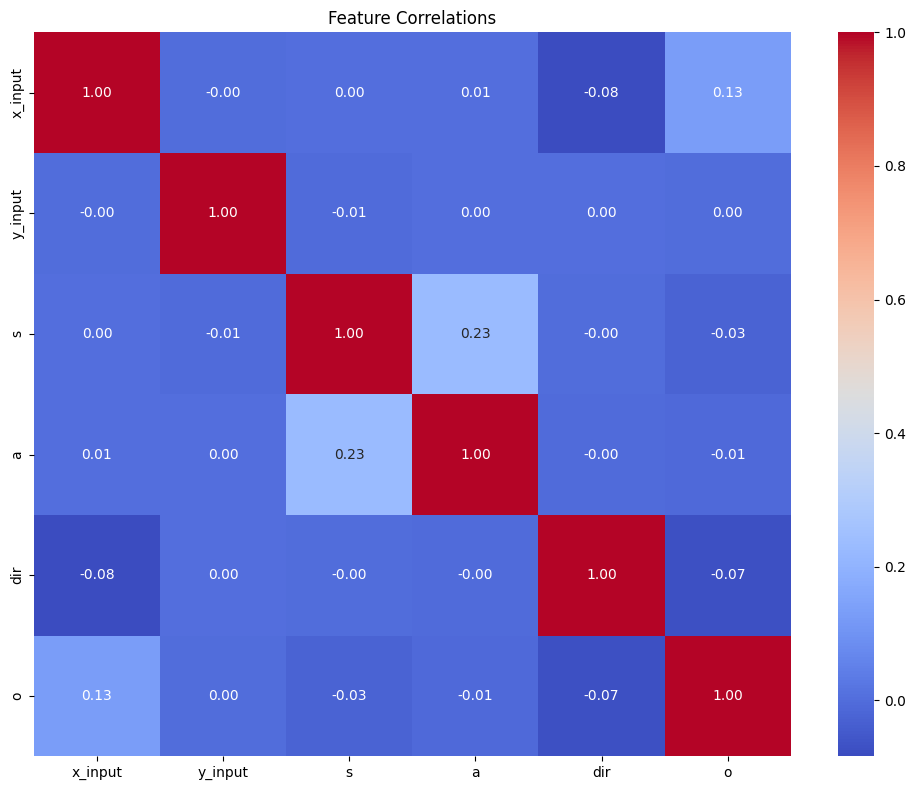

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

## Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (3707330, 6)
Test: (926833, 6)


## Feature Scaling

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

Scaled train shape: (3707330, 6)
Scaled test shape: (926833, 6)


## Convert to PyTorch Tensors

In [11]:
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

print(f"Train tensor shape: {X_train_tensor.shape}")
print(f"Test tensor shape: {X_test_tensor.shape}")
print(f"Train tensors on device: {X_train_tensor.device}")
print(f"Test tensors on device: {X_test_tensor.device}")

Train tensor shape: torch.Size([3707330, 6])
Test tensor shape: torch.Size([926833, 6])
Train tensors on device: cuda:0
Test tensors on device: cuda:0


## Create DataLoader

In [12]:
batch_size = 1024

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 1024
Training batches: 3621
Test batches: 906


## Define Model

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(input_size=6, hidden_sizes=[100, 50], output_size=2)
model = model.to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

MLP(
  (fc1): Linear(in_features=6, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
)

Total parameters: 5,852


## Define Loss and Optimizer

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__}")

Loss function: MSELoss()
Optimizer: Adam


## GPU Optimization Settings

In [15]:
# Enable GPU optimizations
if device.type == 'cuda':
    torch.cuda.empty_cache()  # Clear GPU cache
    torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner for better performance
    torch.backends.cudnn.deterministic = False  # Faster but less deterministic
    print("GPU optimizations enabled")
    print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")
    print(f"GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f}GB / {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f}GB")

GPU optimizations enabled
cuDNN benchmark: True
GPU memory: 0.15GB / 17.09GB


## Train Model

In [16]:
epochs = 50
train_losses = []
test_losses = []

start = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # No need to move to device - already on GPU
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

train_time = time.time() - start
print(f"\nTraining time: {train_time:.4f}s")

Epoch [10/50], Train Loss: 40.3099, Test Loss: 40.4302
Epoch [20/50], Train Loss: 40.0466, Test Loss: 40.1463
Epoch [20/50], Train Loss: 40.0466, Test Loss: 40.1463
Epoch [30/50], Train Loss: 39.9140, Test Loss: 39.9293
Epoch [30/50], Train Loss: 39.9140, Test Loss: 39.9293
Epoch [40/50], Train Loss: 39.8375, Test Loss: 39.9427
Epoch [40/50], Train Loss: 39.8375, Test Loss: 39.9427
Epoch [50/50], Train Loss: 39.7504, Test Loss: 39.7763

Training time: 1235.1285s
Epoch [50/50], Train Loss: 39.7504, Test Loss: 39.7763

Training time: 1235.1285s


## Training Loss

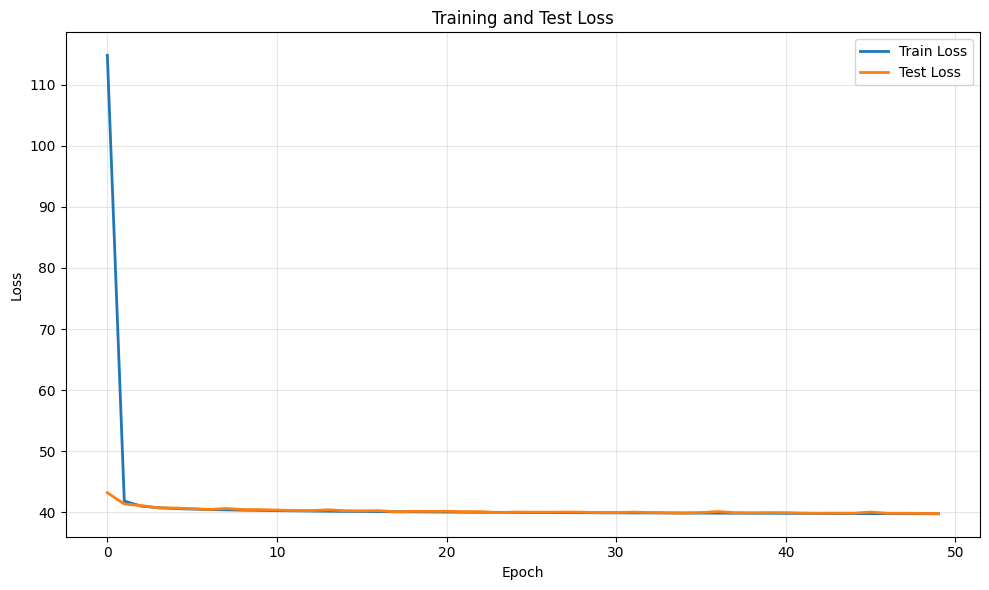

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Predictions

In [18]:
model.eval()

start = time.time()
with torch.no_grad():
    # Process in batches to optimize memory usage
    y_train_pred = model(X_train_tensor).cpu().numpy()
train_pred_time = time.time() - start

start = time.time()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()
test_pred_time = time.time() - start

print(f"Train prediction time: {train_pred_time:.4f}s")
print(f"Test prediction time: {test_pred_time:.4f}s")

Train prediction time: 0.0489s
Test prediction time: 0.0064s


## Metrics

In [19]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")

Train RMSE: 6.2841
Test RMSE: 6.3045
Train R2: 0.8698
Test R2: 0.8695


## Metrics Summary

In [20]:
metrics_df = pd.DataFrame({
    'Metric': [
        'Train Time',
        'Train Pred Time',
        'Test Pred Time',
        'Train RMSE',
        'Test RMSE',
        'Train R2',
        'Test R2'
    ],
    'Value': [
        f'{train_time:.4f}s',
        f'{train_pred_time:.4f}s',
        f'{test_pred_time:.4f}s',
        f'{train_rmse:.4f}',
        f'{test_rmse:.4f}',
        f'{train_r2:.4f}',
        f'{test_r2:.4f}'
    ]
})

metrics_df

,Metric,Value
0,Train Time,1235.1285s
1,Train Pred Time,0.0489s
2,Test Pred Time,0.0064s
3,Train RMSE,6.2841
4,Test RMSE,6.3045
5,Train R2,0.8698
6,Test R2,0.8695


## Predictions vs Actual

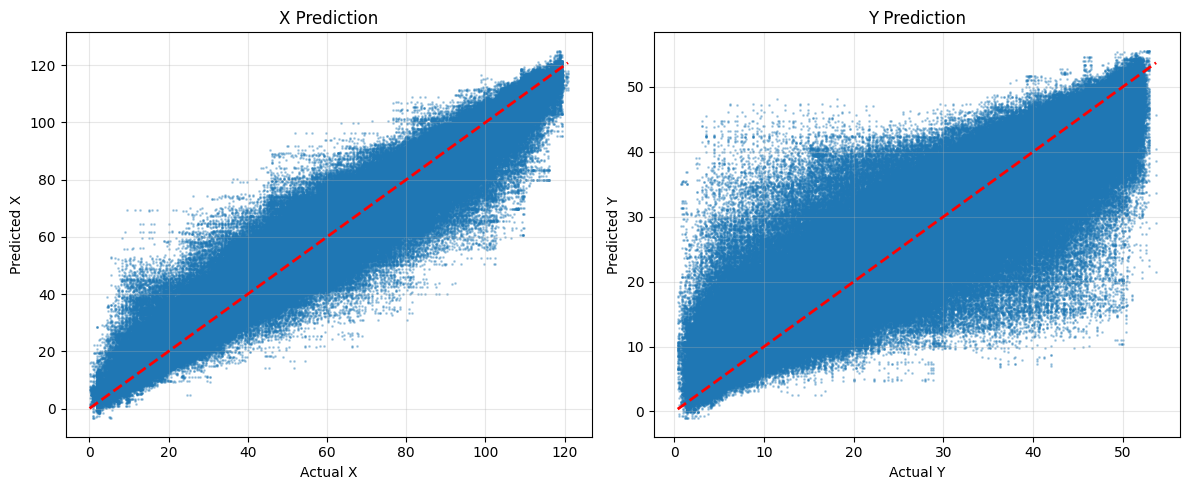

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test.iloc[:, 0], y_test_pred[:, 0], alpha=0.3, s=1)
axes[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
             [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
             'r--', linewidth=2)
axes[0].set_xlabel('Actual X')
axes[0].set_ylabel('Predicted X')
axes[0].set_title('X Prediction')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test.iloc[:, 1], y_test_pred[:, 1], alpha=0.3, s=1)
axes[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 
             [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 
             'r--', linewidth=2)
axes[1].set_xlabel('Actual Y')
axes[1].set_ylabel('Predicted Y')
axes[1].set_title('Y Prediction')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Prediction Errors

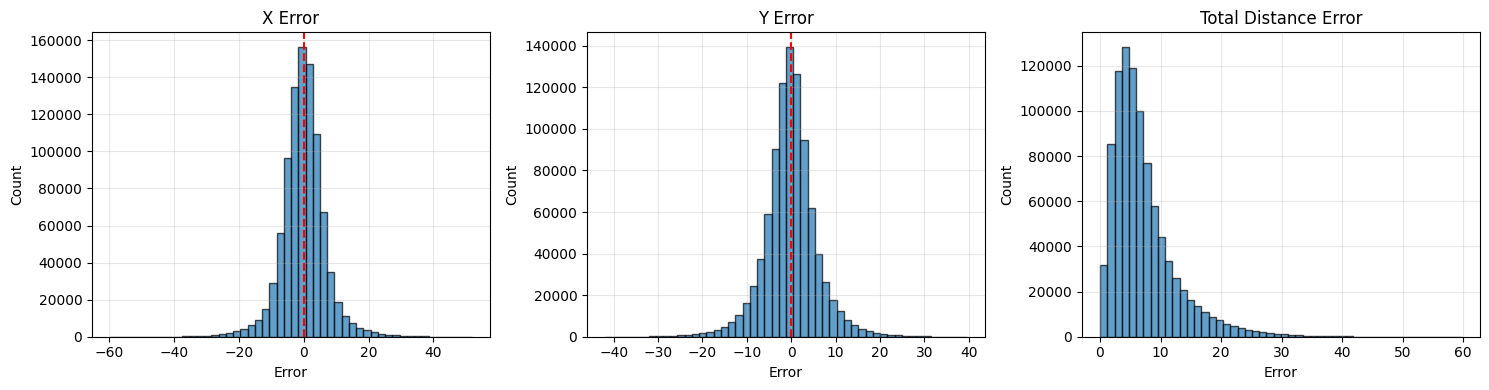

Mean error: 7.1465
Median error: 5.7823


In [22]:
errors_x = y_test['x_output'].values - y_test_pred[:, 0]
errors_y = y_test['y_output'].values - y_test_pred[:, 1]
errors_total = np.sqrt(errors_x**2 + errors_y**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(errors_x, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Count')
axes[0].set_title('X Error')
axes[0].grid(alpha=0.3)

axes[1].hist(errors_y, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Count')
axes[1].set_title('Y Error')
axes[1].grid(alpha=0.3)

axes[2].hist(errors_total, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Error')
axes[2].set_ylabel('Count')
axes[2].set_title('Total Distance Error')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {errors_total.mean():.4f}")
print(f"Median error: {np.median(errors_total):.4f}")

## Feature Importance

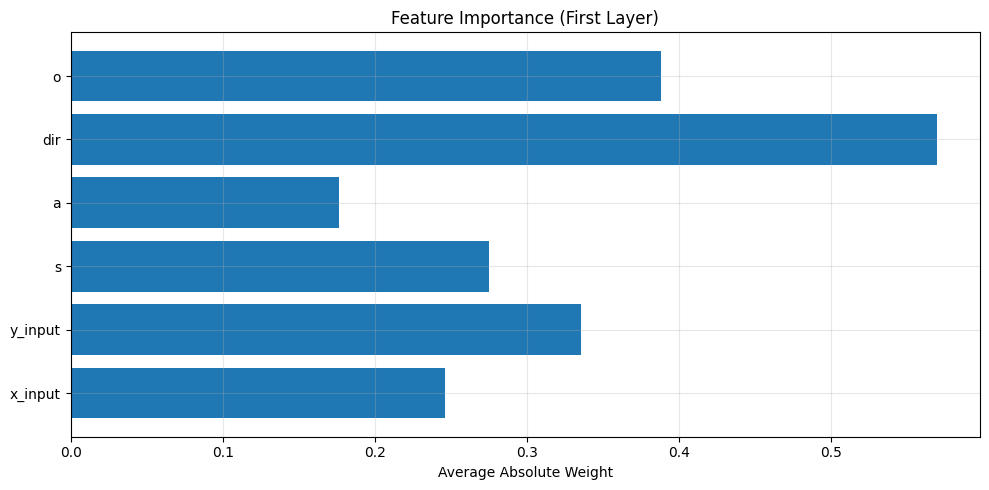

In [23]:
first_layer_weights = model.fc1.weight.data.cpu().numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)

plt.figure(figsize=(10, 5))
plt.barh(feature_cols, feature_importance)
plt.xlabel('Average Absolute Weight')
plt.title('Feature Importance (First Layer)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()